# Statistical Analyses of Fake Job Postings Dataset

In [1]:
# import libraries
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import statsmodels.api as sm


from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import (accuracy_score, average_precision_score, 
                             balanced_accuracy_score, jaccard_score, f1_score, 
                             recall_score, roc_auc_score, precision_score)
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

In [2]:
# import data and have a peek at the first 3 rows
df = pd.read_csv('C:/Users/nickm/Desktop/Coding/Projects/fake-job-postings/fake_job_postings_CLEANED_RECODED.gzip', compression='gzip')
df.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,required_education_Associate Degree,required_education_Bachelor's Degree,required_education_Doctorate,required_education_High School or equivalent,required_education_Master's Degree,required_education_Some College Coursework Completed,required_education_Some High School Coursework,required_education_Unspecified,required_education_Prof_Voca_Cert,required_education_short
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Predicting Fraudulent Jobs Based on Numeric Features

### Feature Inspection and Column Selection

In [3]:
# Define columns to inspect and display descriptive statistics
num_cols = df.dtypes[df.dtypes != 'object'].index.to_list()

df[num_cols].astype(float).describe().T

,count,mean,std,min,25%,50%,75%,max
job_id,17598.0,8898.866746,5166.312506,1.000000,4422.25,8861.5,13373.75,17880.0
telecommuting,17598.0,0.042846,0.202515,0.000000,0.00,0.0,0.00,1.0
has_company_logo,17598.0,0.794181,0.404310,0.000000,1.00,1.0,1.00,1.0
has_questions,17598.0,0.492045,0.499951,0.000000,0.00,0.0,1.00,1.0
fraudulent,17598.0,0.048585,0.215005,0.000000,0.00,0.0,0.00,1.0
has_company_profile,17598.0,0.813558,0.389474,0.000000,1.00,1.0,1.00,1.0
has_description,17598.0,1.000000,0.000000,1.000000,1.00,1.0,1.00,1.0
has_requirements,17598.0,0.849528,0.357543,0.000000,1.00,1.0,1.00,1.0
has_benefits,17598.0,0.596147,0.490683,0.000000,0.00,1.0,1.00,1.0
company_profile_length,14317.0,761.595656,536.958467,9.000000,391.00,684.0,1022.00,6178.0


### Remove Unused Columns

In [4]:
# Exclude certain columns from the analysis
excluded_columns = []

# job_id
excluded_columns.append('job_id')

# 'has_description' is a constant - every job in our dataset has a description
excluded_columns.append('has_description')

# Salary ranges - too many missings and uncertainty regarding proper format (yearly, monthly, k,...)
excluded_columns.extend(['salary_range_from', 'salary_range_to', 'salary_range_mid', 'salary_range_peak_to_peak'])

# Text passage presence dummies - perfectly correlated with passage length
excluded_columns.extend(['has_company_profile', 'has_requirements', 'has_benefits',])

# Overall job posting length - highly correlated with lengths individual passage lengths
# ALTERNATIVELY: Drop length variables and keep has_... variables
excluded_columns.append('job_posting_length')

# Exclude columns from list
num_cols = [col for col in num_cols if col not in excluded_columns]

### Feature Correlation

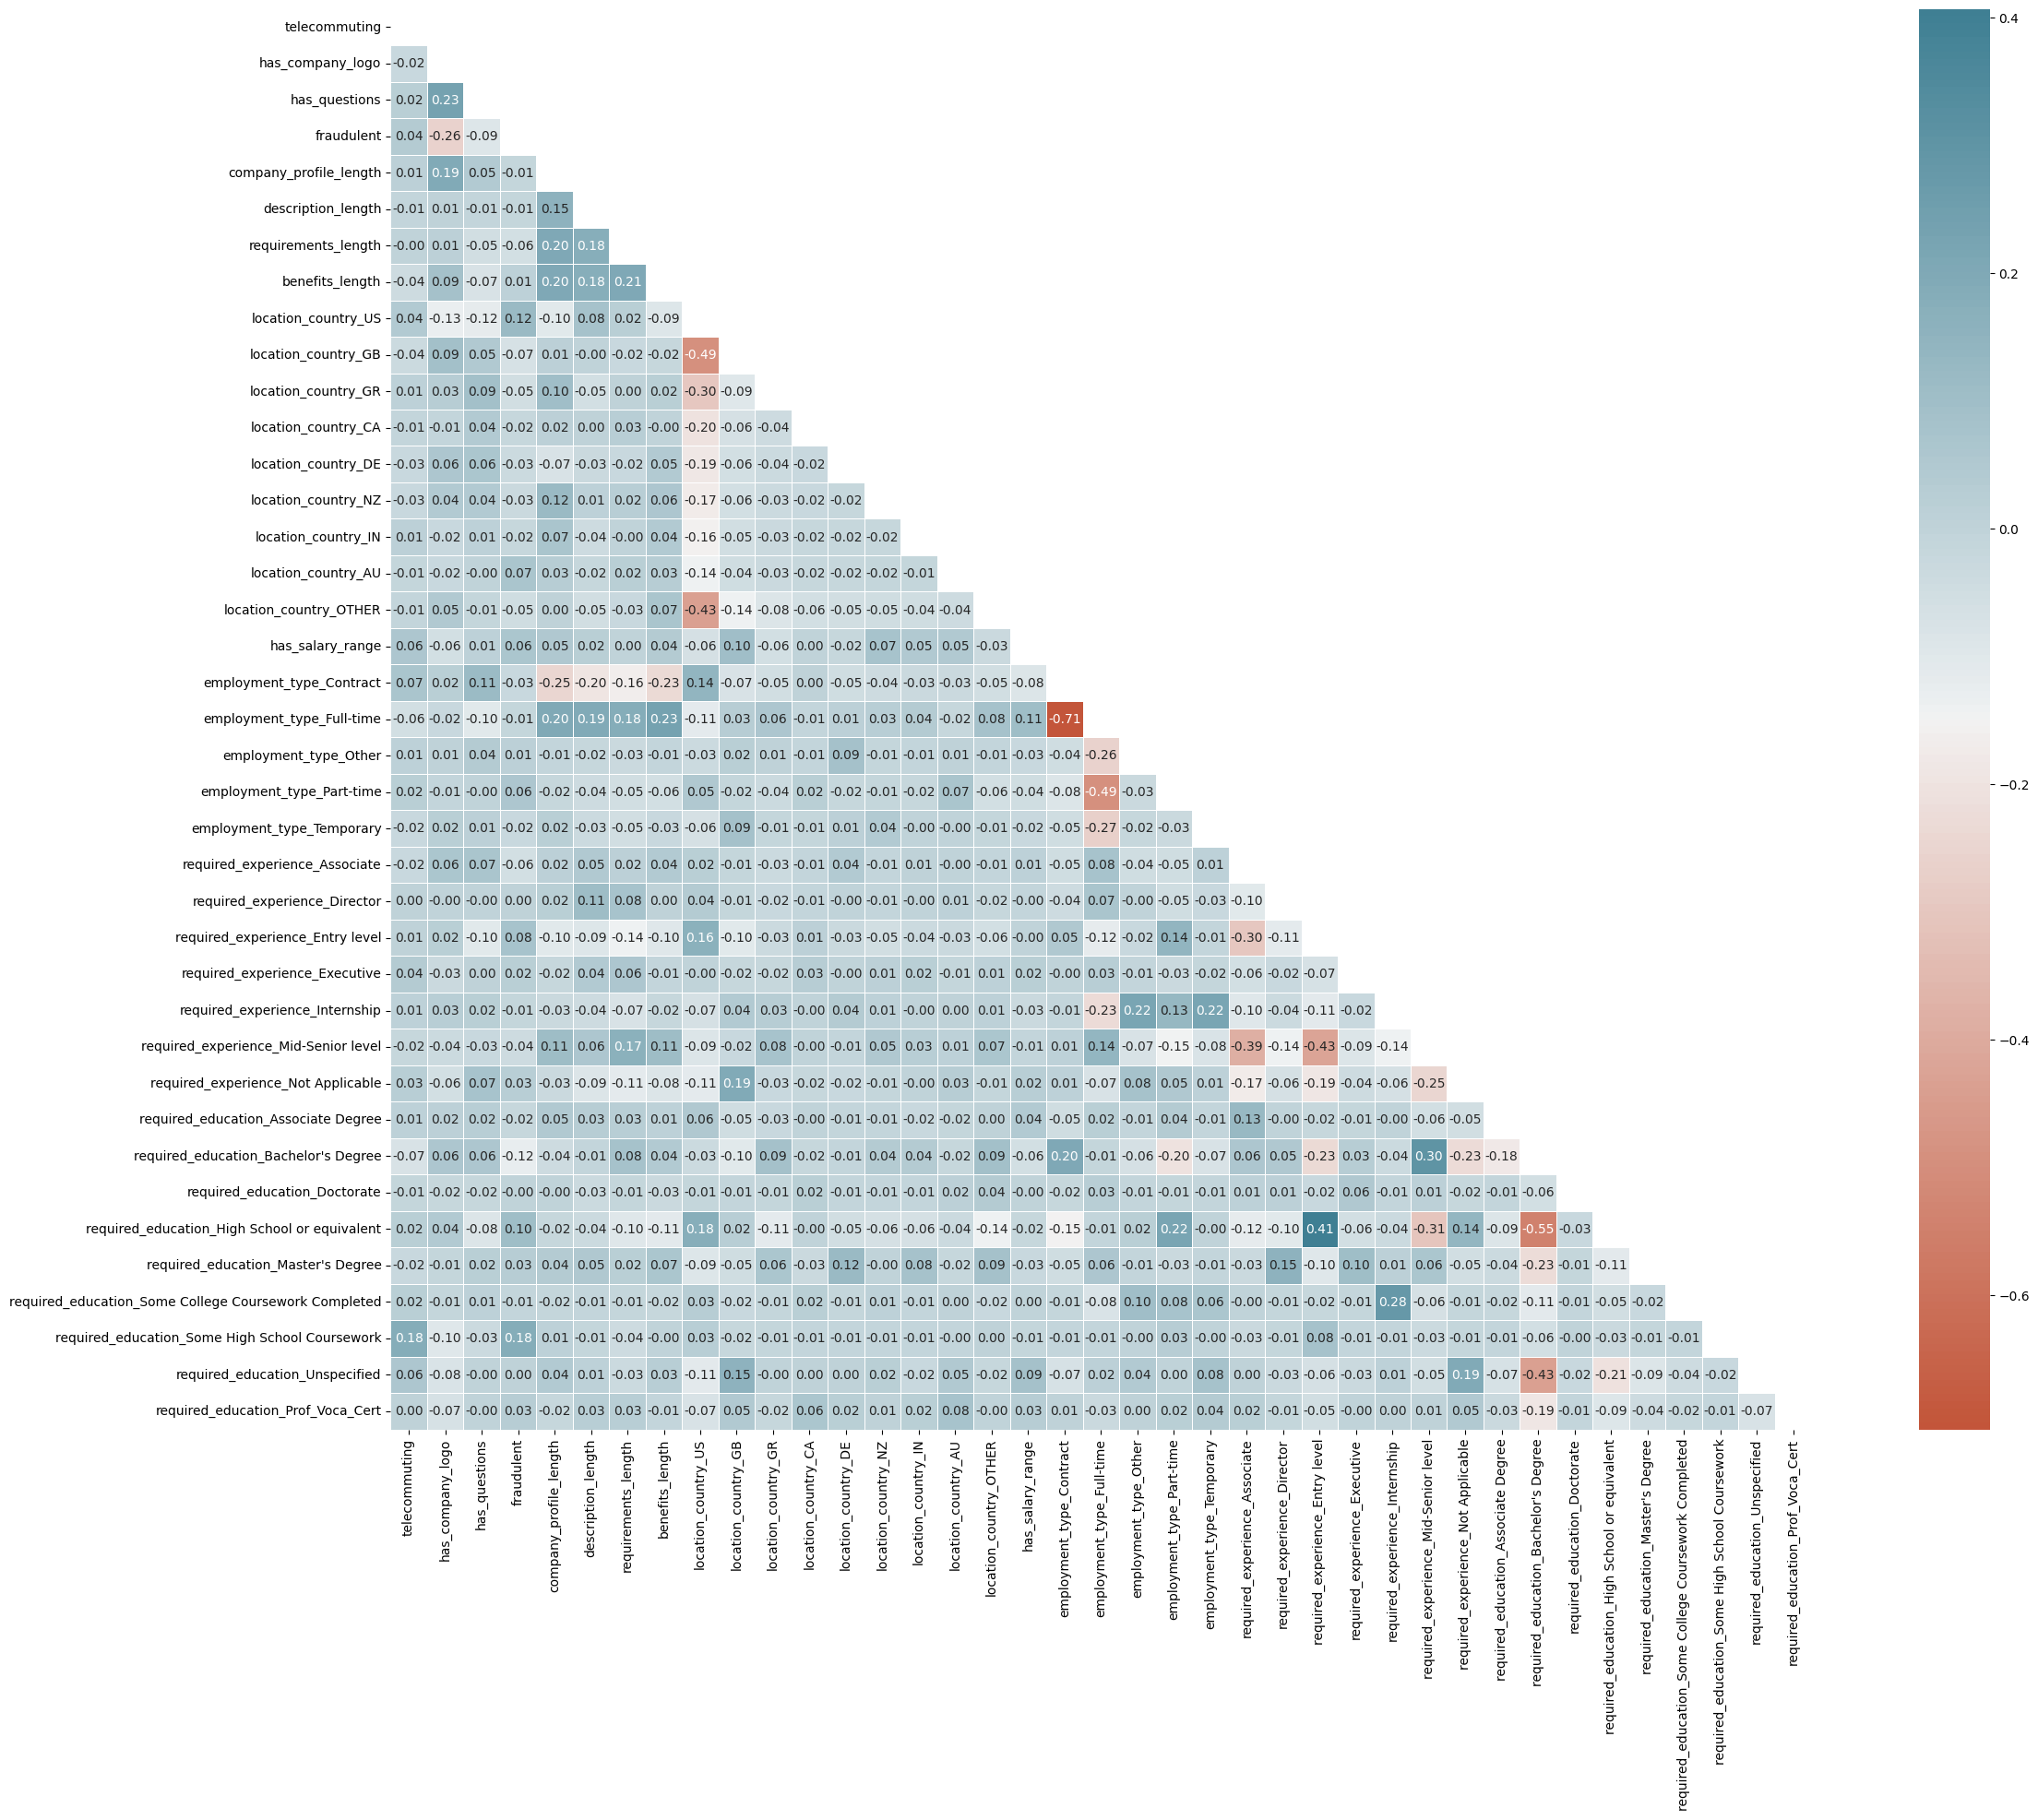

In [5]:
correlations = df[num_cols].corr()

plt.figure(figsize=(30,20))
sns.heatmap(correlations,
            mask=np.triu(correlations),
            square=True,
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            cmap=sns.diverging_palette(20, 220, n=200));

### Jaccard Similarities for Dichotomous Features

In [6]:
# Build jaccard function with sklearn.jaccard_score
def jaccard_matrix(data):
    cols = data.columns
    n_cols = len(cols)
    results = np.empty((n_cols,n_cols)) * np.nan

    for result_row, y_col in enumerate(cols):
        for result_col, x_col in enumerate(cols):
            # to only populate lower diagonal part of result matrix, skip to next iteration when x == y
            if result_row == result_col:
                break
            # exclude missings pairwise
            temp_df = df[[y_col, x_col]].dropna()
            
            results[result_row][result_col] = jaccard_score(temp_df[y_col], temp_df[x_col])
    
    return pd.DataFrame(results, index=cols, columns=cols)

In [7]:
# Select only dichotomous columns
bool_cols = [col for col in num_cols if not col.__contains__('length')]
# Compute jaccard_similarities
jaccard_similarities = jaccard_matrix(df[bool_cols])
jaccard_similarities.head()

,telecommuting,has_company_logo,has_questions,fraudulent,location_country_US,location_country_GB,location_country_GR,location_country_CA,location_country_DE,location_country_NZ,...,required_experience_Not Applicable,required_education_Associate Degree,required_education_Bachelor's Degree,required_education_Doctorate,required_education_High School or equivalent,required_education_Master's Degree,required_education_Some College Coursework Completed,required_education_Some High School Coursework,required_education_Unspecified,required_education_Prof_Voca_Cert
telecommuting,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_company_logo,0.040107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_questions,0.044960,0.516380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fraudulent,0.041424,0.019383,0.026875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location_country_US,0.048132,0.482625,0.325847,0.06818,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


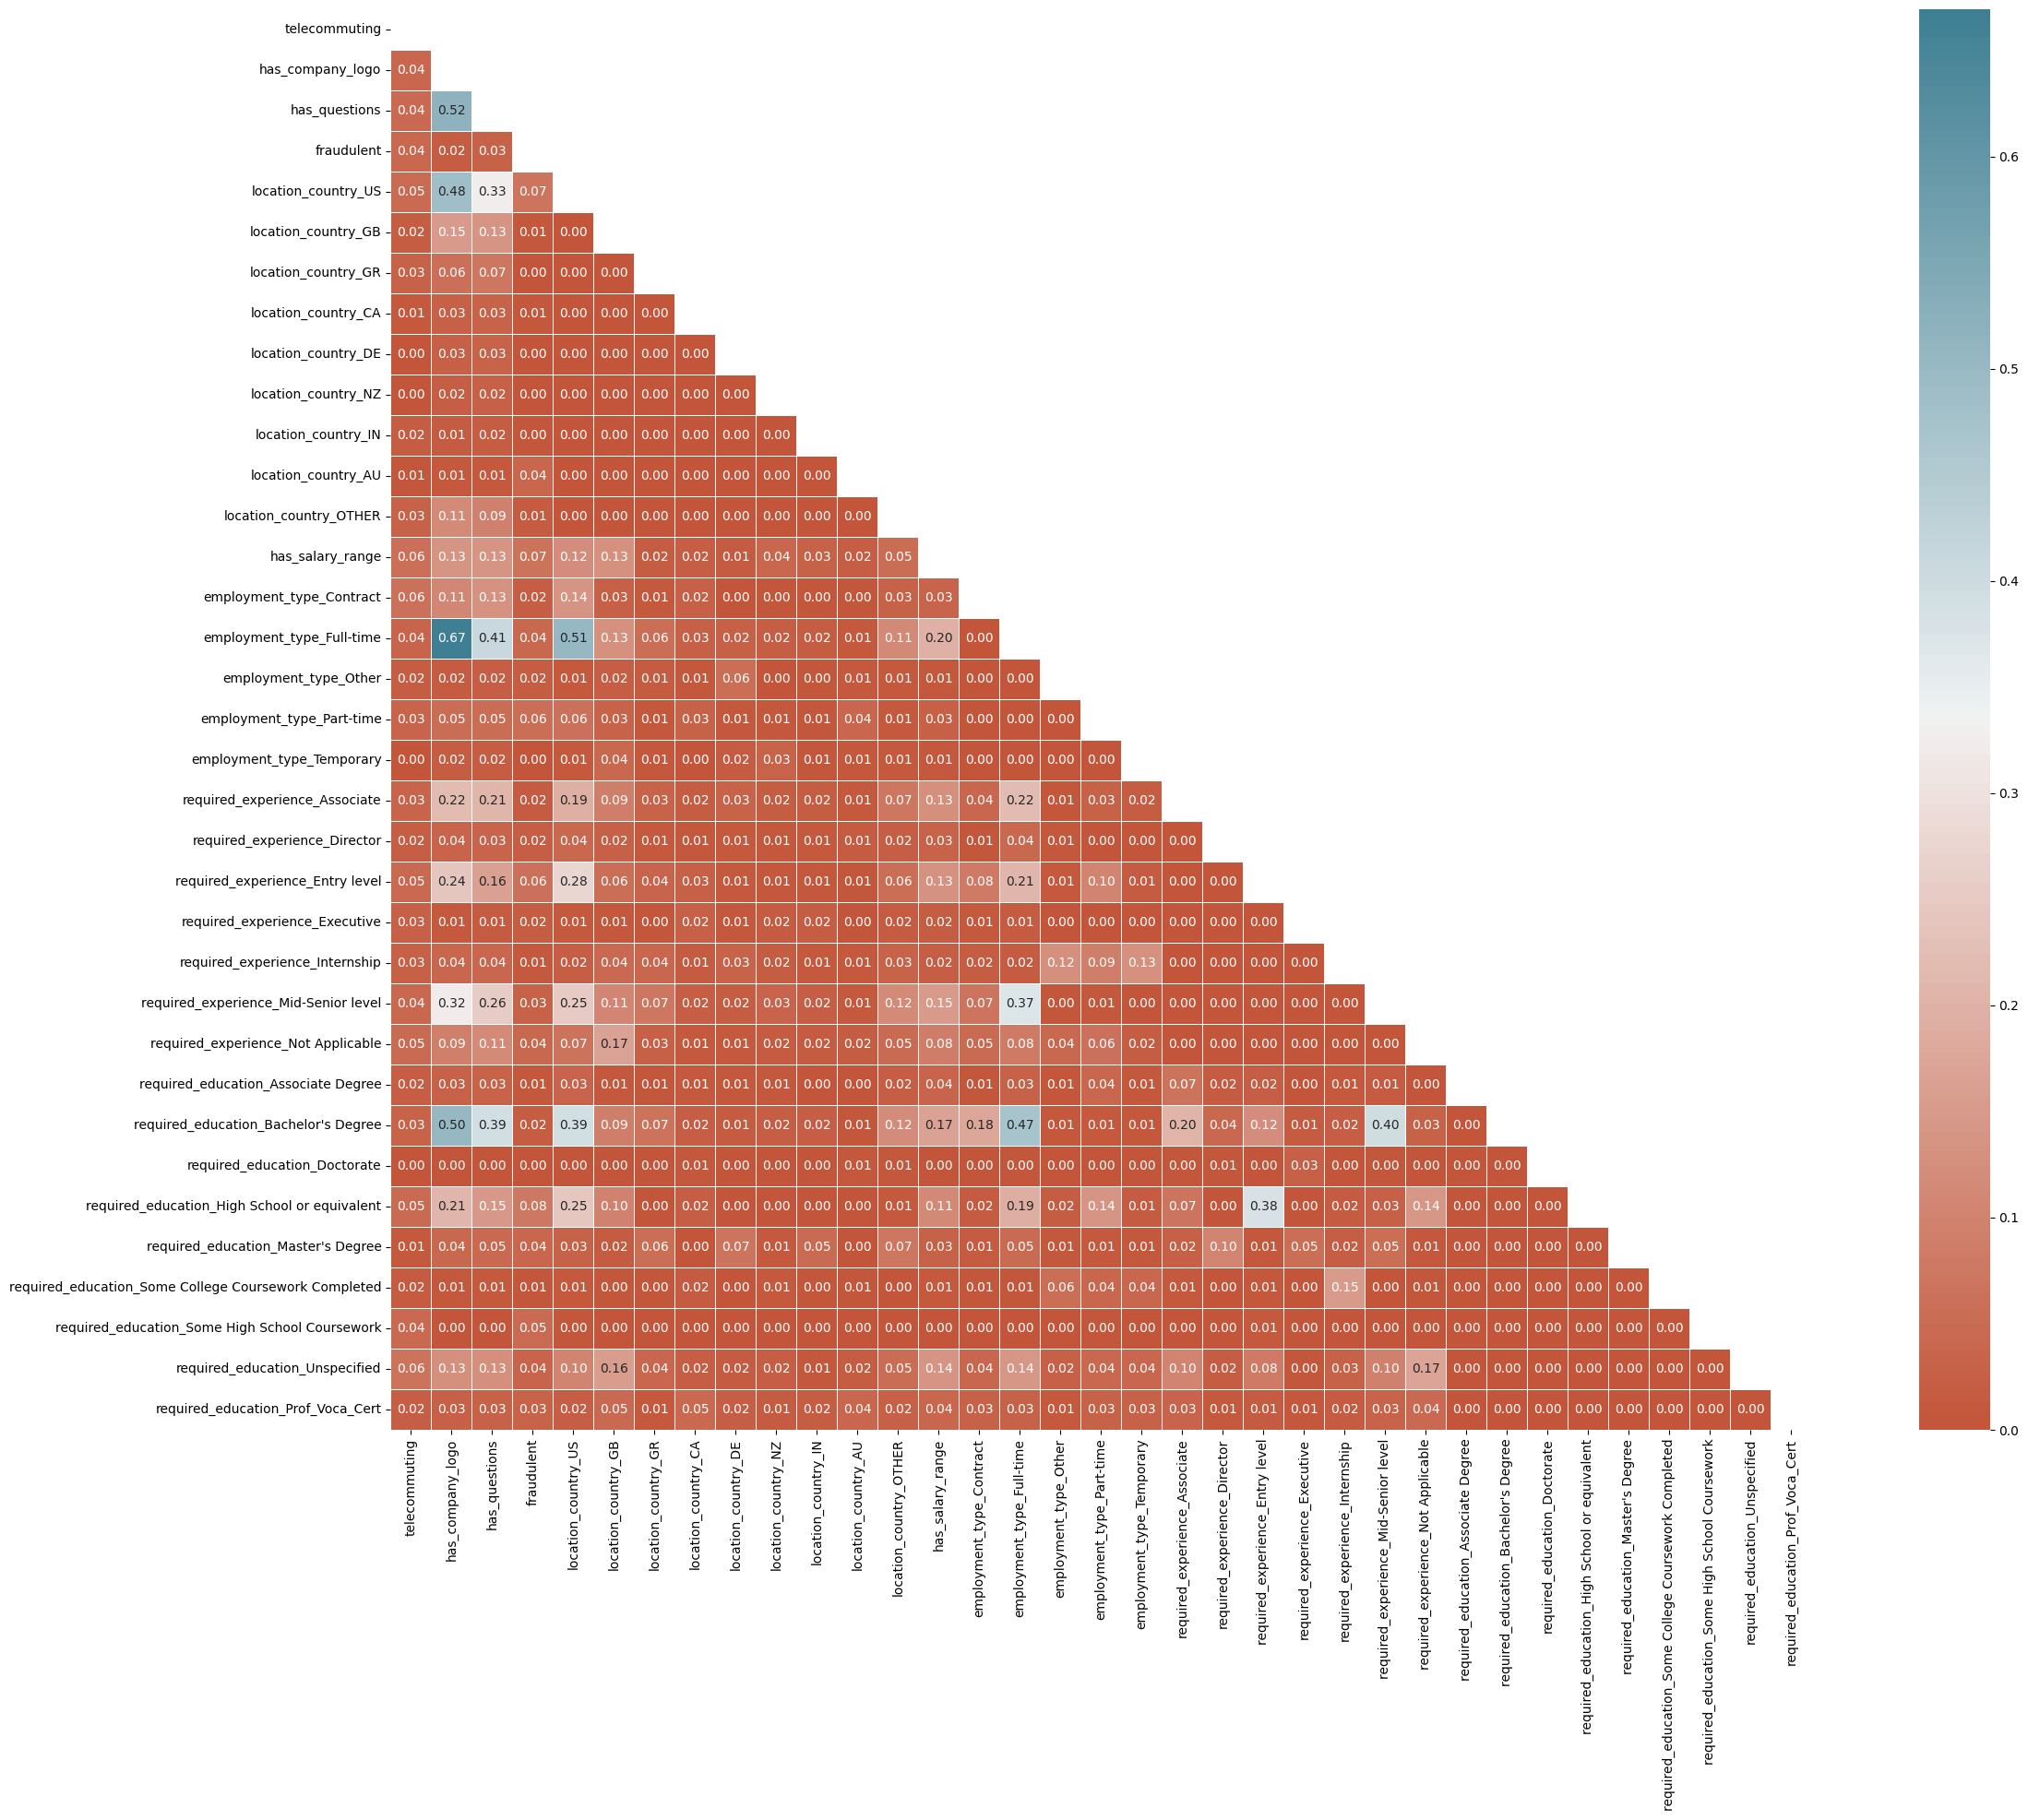

In [8]:
# plot jaccard scores
plt.figure(figsize=(30,20))
sns.heatmap(jaccard_similarities,
            square=True,
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            cmap=sns.diverging_palette(20, 220, n=200));

### Missings

In [9]:
# print number of missings per column
df[num_cols].isna().sum()

telecommuting                                              0
has_company_logo                                           0
has_questions                                              0
fraudulent                                                 0
company_profile_length                                  3281
description_length                                         0
requirements_length                                     2648
benefits_length                                         7107
location_country_US                                      341
location_country_GB                                      341
location_country_GR                                      341
location_country_CA                                      341
location_country_DE                                      341
location_country_NZ                                      341
location_country_IN                                      341
location_country_AU                                      341
location_country_OTHER  

## Dataset Split

In [10]:
# Define y and X and split dataset
y = df['fraudulent']
X = df[num_cols].drop('fraudulent', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
# print distribution
print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)
print(f'y_train shape: {y_train.shape}, fraudulent jobs: {sum(y_train)} ({round(sum(y_train)/len(y_train)*100, 2)}%)')
print(f'y_test shape:  {y_test.shape},  fraudulent jobs: {sum(y_test)} ({round(sum(y_test)/len(y_test)*100, 2)}%)')

X_train shape: (14078, 38)
X_test shape:  (3520, 38)
y_train shape: (14078,), fraudulent jobs: 684 (4.86%)
y_test shape:  (3520,),  fraudulent jobs: 171 (4.86%)


## Model Selection via Cross-Validation

In [12]:
# Define classifier models and store in dictionary
dtc = DecisionTreeClassifier(random_state=42)
rfc = RandomForestClassifier(random_state=42)
xgbc = XGBClassifier(random_state=42)
hgbc = HistGradientBoostingClassifier(random_state=42)
gbmc = lgb.LGBMClassifier(random_state=42, verbose=-1)
cbc = CatBoostClassifier(random_state=42, verbose=0)

models = {'DecisionTree': dtc,
          'Random Forest': rfc,
          'XGBoost': xgbc,
          'Histogram-based Gradient Boosting': hgbc,
          'LightGBM': gbmc,
          'CatBoost': cbc}

In [13]:
# Define metrics to be evaluated and splitting strategy
scoring = ['accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1', 'roc_auc', 'average_precision']
n_fold = 5

# Run cross-validation with 5-fold split for each model
scores = {key: [] for key in models.keys()}
for model_name, model in models.items():
    scores[model_name] = cross_validate(model, X, y, cv=n_fold, scoring=scoring, n_jobs=-1)

c:\Users\nickm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nickm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\nickm\AppData\Local\Programs\Python\Python311\Lib\site-packages\catboost\core.py", line 5201, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_mo

In [14]:
# show exemplary results
scores['DecisionTree']

{'fit_time': array([0.17488885, 0.15886521, 0.17488885, 0.15886521, 0.14292359]),
 'score_time': array([0.03147101, 0.03186178, 0.01583815, 0.03186178, 0.03196526]),
 'test_accuracy': array([0.94630682, 0.95284091, 0.96392045, 0.9599318 , 0.96533106]),
 'test_balanced_accuracy': array([0.74980836, 0.780989  , 0.77293824, 0.78194366, 0.84304848]),
 'test_recall': array([0.53216374, 0.59064327, 0.56140351, 0.58479532, 0.70760234]),
 'test_precision': array([0.455     , 0.51269036, 0.64864865, 0.58823529, 0.62694301]),
 'test_f1': array([0.49056604, 0.54891304, 0.60188088, 0.58651026, 0.66483516]),
 'test_roc_auc': array([0.74980836, 0.780989  , 0.77293824, 0.78194366, 0.84304848]),
 'test_average_precision': array([0.26486178, 0.32270347, 0.38546045, 0.36417343, 0.45783492])}

In [15]:
# store results score wise for all models and for all cross-validation runs
all_scores = {key: [] for key in scores[list(scores.keys())[0]]}
model_names = []

for model_name, model_results in scores.items():
    model_names.extend([model_name]*n_fold)
    for score, score_results in model_results.items():
        all_scores[score].extend(score_results)

In [16]:
# show keys
all_scores.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_balanced_accuracy', 'test_recall', 'test_precision', 'test_f1', 'test_roc_auc', 'test_average_precision'])

In [17]:
# store results in a dataframe with columns for model_name and run id.
all_results = pd.concat([pd.Series(model_names).rename('model_name'),
                         pd.Series([n for n in range(n_fold)]*len(models)).rename('run'),
                         pd.DataFrame(all_scores)], axis=1)
all_results.head(7)

,model_name,run,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_recall,test_precision,test_f1,test_roc_auc,test_average_precision
0,DecisionTree,0,0.174889,0.031471,0.946307,0.749808,0.532164,0.455000,0.490566,0.749808,0.264862
1,DecisionTree,1,0.158865,0.031862,0.952841,0.780989,0.590643,0.512690,0.548913,0.780989,0.322703
2,DecisionTree,2,0.174889,0.015838,0.963920,0.772938,0.561404,0.648649,0.601881,0.772938,0.385460
3,DecisionTree,3,0.158865,0.031862,0.959932,0.781944,0.584795,0.588235,0.586510,0.781944,0.364173
4,DecisionTree,4,0.142924,0.031965,0.965331,0.843048,0.707602,0.626943,0.664835,0.843048,0.457835
5,Random Forest,0,2.664910,0.156649,0.970739,0.737676,0.479532,0.854167,0.614232,0.952944,0.714779
6,Random Forest,1,2.554600,0.173346,0.971307,0.749073,0.502924,0.843137,0.630037,0.962687,0.736167


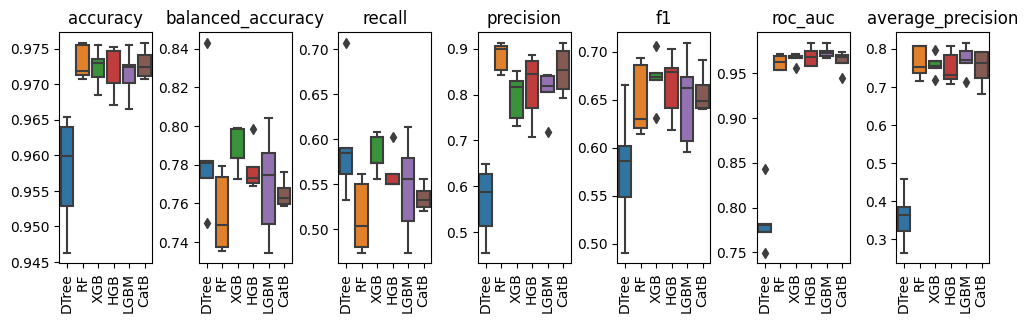

In [18]:
# Plot each scoring metric grouped by model
metrics = all_results.filter(like='test').columns

fig, axs = plt.subplots(figsize=(12,3), ncols=len(metrics))
plt.subplots_adjust(wspace=0.5)

for axis, metric in enumerate(metrics):
    sns.boxplot(data=all_results, x='model_name', y=metric, ax=axs[axis])
    axs[axis].set(title=metric.replace('test_', ''), ylabel='', xlabel='')
    axs[axis].set_xticklabels(['DTree', 'RF', 'XGB', 'HGB', 'LGBM', 'CatB'], rotation=90)

In order to evaluate the models based on this visualization, we'll look at the distribution of the 5 cv splits. More precisely, we look at the variability of the data, mean, median and the interquartile range.

Based on this, 3 models stick out:
- Random Forest with best performance in terms of accuracy, precision and PR-AUC (i.e. average precision)
- XGBoost with best performance in balanced accuracy, recall and F1 score
- LightGBM for best performance in terms of ROC-AUC

In [19]:
# Let's confirm this by looking at the mean values
mean_results = all_results.drop('run', axis=1).groupby(by='model_name', sort=False).mean()
# rename index and transpose dataframe
mean_results_T = mean_results.rename(index={'Histogram-based Gradient Boosting': 'HGB'}).T
# add index of maximum in column
pd.concat([mean_results_T, mean_results.idxmax(0)], axis=1).rename(columns={0:'Classifier with Max Value'})

,DecisionTree,Random Forest,XGBoost,HGB,LightGBM,CatBoost,Classifier with Max Value
fit_time,0.162086,3.087973,0.721048,1.974876,1.196432,22.931032,CatBoost
score_time,0.028600,0.205524,0.108761,0.221756,0.097196,0.061535,Histogram-based Gradient Boosting
test_accuracy,0.957666,0.973065,0.972327,0.972383,0.971474,0.972866,Random Forest
test_balanced_accuracy,0.785746,0.754993,0.787346,0.777942,0.769695,0.765155,XGBoost
test_recall,0.595322,0.513450,0.582456,0.562573,0.546199,0.535088,DecisionTree
test_precision,0.566303,0.883117,0.795477,0.816208,0.805320,0.853687,Random Forest
test_f1,0.578541,0.648846,0.671883,0.665021,0.649516,0.657355,XGBoost
test_roc_auc,0.785746,0.961768,0.966251,0.968329,0.973317,0.963597,LightGBM
test_average_precision,0.359007,0.763369,0.757382,0.750082,0.770989,0.750305,LightGBM


In [20]:
# have a closer look at the 3 models mentioned earlier, i.e. Random Forest, XGBoost, and LightGBM
mean_results.drop(['fit_time', 'score_time'], axis=1).loc[['Random Forest', 'XGBoost', 'LightGBM']].T

model_name,Random Forest,XGBoost,LightGBM
test_accuracy,0.973065,0.972327,0.971474
test_balanced_accuracy,0.754993,0.787346,0.769695
test_recall,0.513450,0.582456,0.546199
test_precision,0.883117,0.795477,0.805320
test_f1,0.648846,0.671883,0.649516
test_roc_auc,0.961768,0.966251,0.973317
test_average_precision,0.763369,0.757382,0.770989


Our sample contains 95.14% of class 0, i.e. non-fraudulent/real, jobs. Dealing with this class imbalance, we'll have to refrain of simply looking at the accuracy metric (A naive estimator predicting only 0 would be right 95.14% of the time). 

Rather, we should be paying attention to precision (the share of positive predictions that were actually correct) and recall (the share of real positives that were identified as such). In addition, metrics that combine/weigh both (i.e. F1 and PR-AUC) can be taken into account.

In our case, precision would depict the share of correctly predicted fraudulent jobs over all predicted fraudulent jobs.
Recall on the other hand is the share of correctly predicted fraudulent jobs over all actual fraudulent jobs.

We have to weigh the cost of these 2 metrics by thinking about their implications. Having a weak precision would lead to classifying real job postings as fraudulent, and therefore missing out the chance to apply for a good position. On the other hand, with insuficient recall, we might misclassify fraudulent jobs as real jobs and thereby risking being scammed.

In some situations, the cost of one metric might outweigh the cost of the other. In our case, both feel equally important.
Hence, we will pick a model that, while not necessarily provides the best score for one metric, does well when looking at both metrics.

For this, we will mainly look at the F1-Score, as this harmonizes the accuracy and precision score.

Thus, the winner is... XGBoost!

## XGBoost

In [21]:
# Train Model
xgbc = XGBClassifier(random_state=42)
#xgbc.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Model Evaluation

In [22]:
# Predict class and probabilities
y_predict = xgbc.predict(X_test)
y_score = pd.DataFrame(xgbc.predict_proba(X_test))[1]

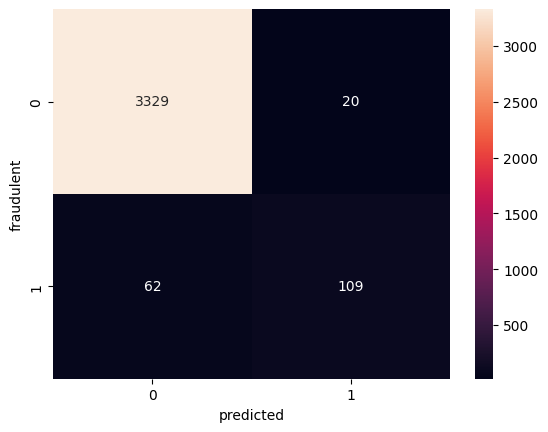

In [23]:
# Display confusion matrix
sns.heatmap(pd.crosstab(y_test, y_predict), annot=True, fmt='d').set_xlabel('predicted');

In [24]:
# print evaluation scores
print('Accuracy          ', round(accuracy_score(y_true=y_test, y_pred=y_predict), 4))
print('Balanced Accuracy ', round(balanced_accuracy_score(y_true=y_test, y_pred=y_predict), 4))
print('Recall            ', round(recall_score(y_true=y_test, y_pred=y_predict), 4))
print('Precision         ', round(precision_score(y_true=y_test, y_pred=y_predict), 4))
print('F1-Score          ', round(f1_score(y_true=y_test, y_pred=y_predict), 4))
print('ROC-AUC           ', round(roc_auc_score(y_true=y_test, y_score=y_score), 4))
print('PR-AUC            ', round(average_precision_score(y_true=y_test, y_score=y_score), 4))

Accuracy           0.9767
Balanced Accuracy  0.8157
Recall             0.6374
Precision          0.845
F1-Score           0.7267
ROC-AUC            0.9792
PR-AUC             0.8121


### Feature Importance

In [25]:
# store feature importance
xgbc_feature_importance = pd.DataFrame({'feature_name': xgbc.feature_names_in_,
                                        'feature_importance': xgbc.feature_importances_})
# sort descending
xgbc_feature_importance = xgbc_feature_importance.sort_values(by='feature_importance', ascending=False)
# show top 5
xgbc_feature_importance.head(5)

,feature_name,feature_importance
1,has_company_logo,0.083669
7,location_country_US,0.071516
3,company_profile_length,0.069276
24,required_experience_Entry level,0.064314
30,required_education_Bachelor's Degree,0.052442


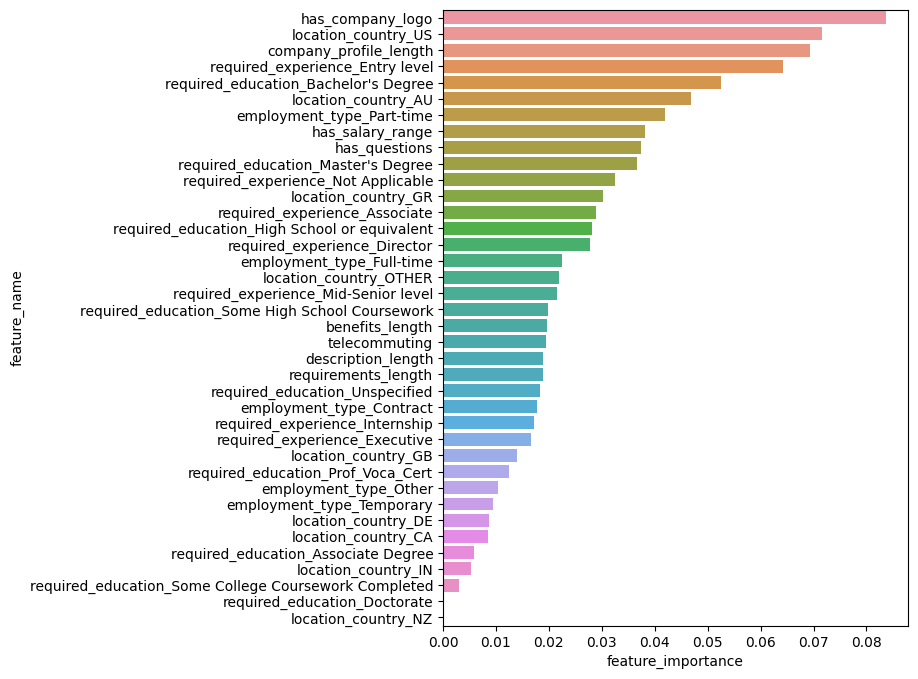

In [26]:
# Plot feature importances
plt.figure(figsize=(6, 8))
sns.barplot(data=xgbc_feature_importance, x='feature_importance', y='feature_name');

### Shapley Values

In [27]:
explainer = shap.TreeExplainer(xgbc.fit(X, y))
shap_values = explainer(X)

In [28]:
feature_importance = pd.DataFrame(list(zip(X.columns, np.abs(shap_values.values).mean(0))),
                                  columns=['feature_name','feature_importance'])
feature_importance['feature_importance_%'] = (feature_importance['feature_importance'] / 
                                              feature_importance['feature_importance'].sum())
feature_importance.sort_values(by='feature_importance',
                               ascending=False, inplace=True)
feature_importance.head()

,feature_name,feature_importance,feature_importance_%
3,company_profile_length,2.104038,0.307738
7,location_country_US,0.662333,0.096873
5,requirements_length,0.473224,0.069214
1,has_company_logo,0.424305,0.062059
6,benefits_length,0.406492,0.059454


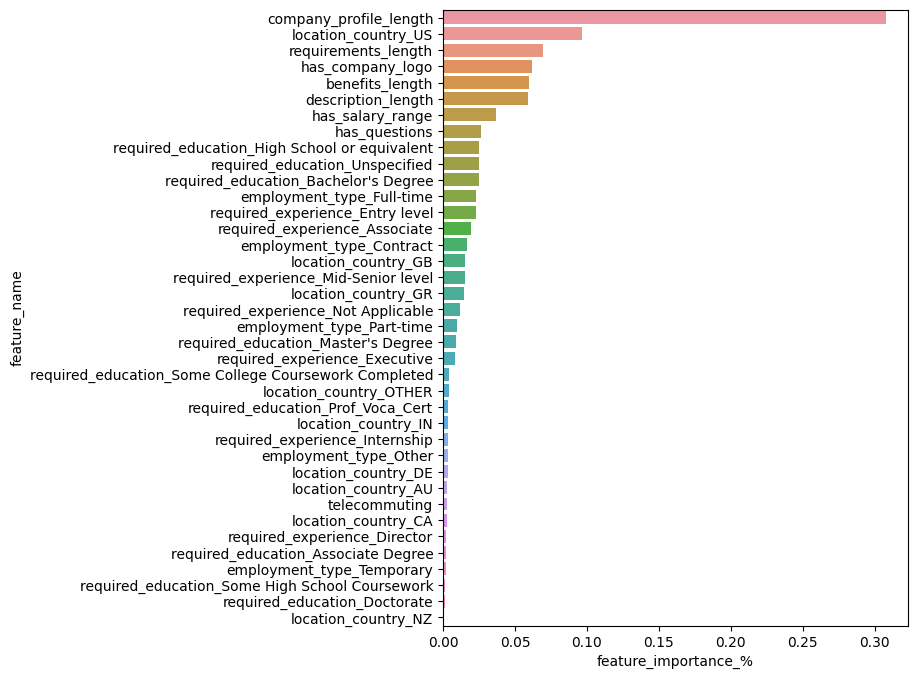

In [29]:
# Plot Shapley Values
plt.figure(figsize=(6, 8))
sns.barplot(data=feature_importance, x='feature_importance_%', y='feature_name');

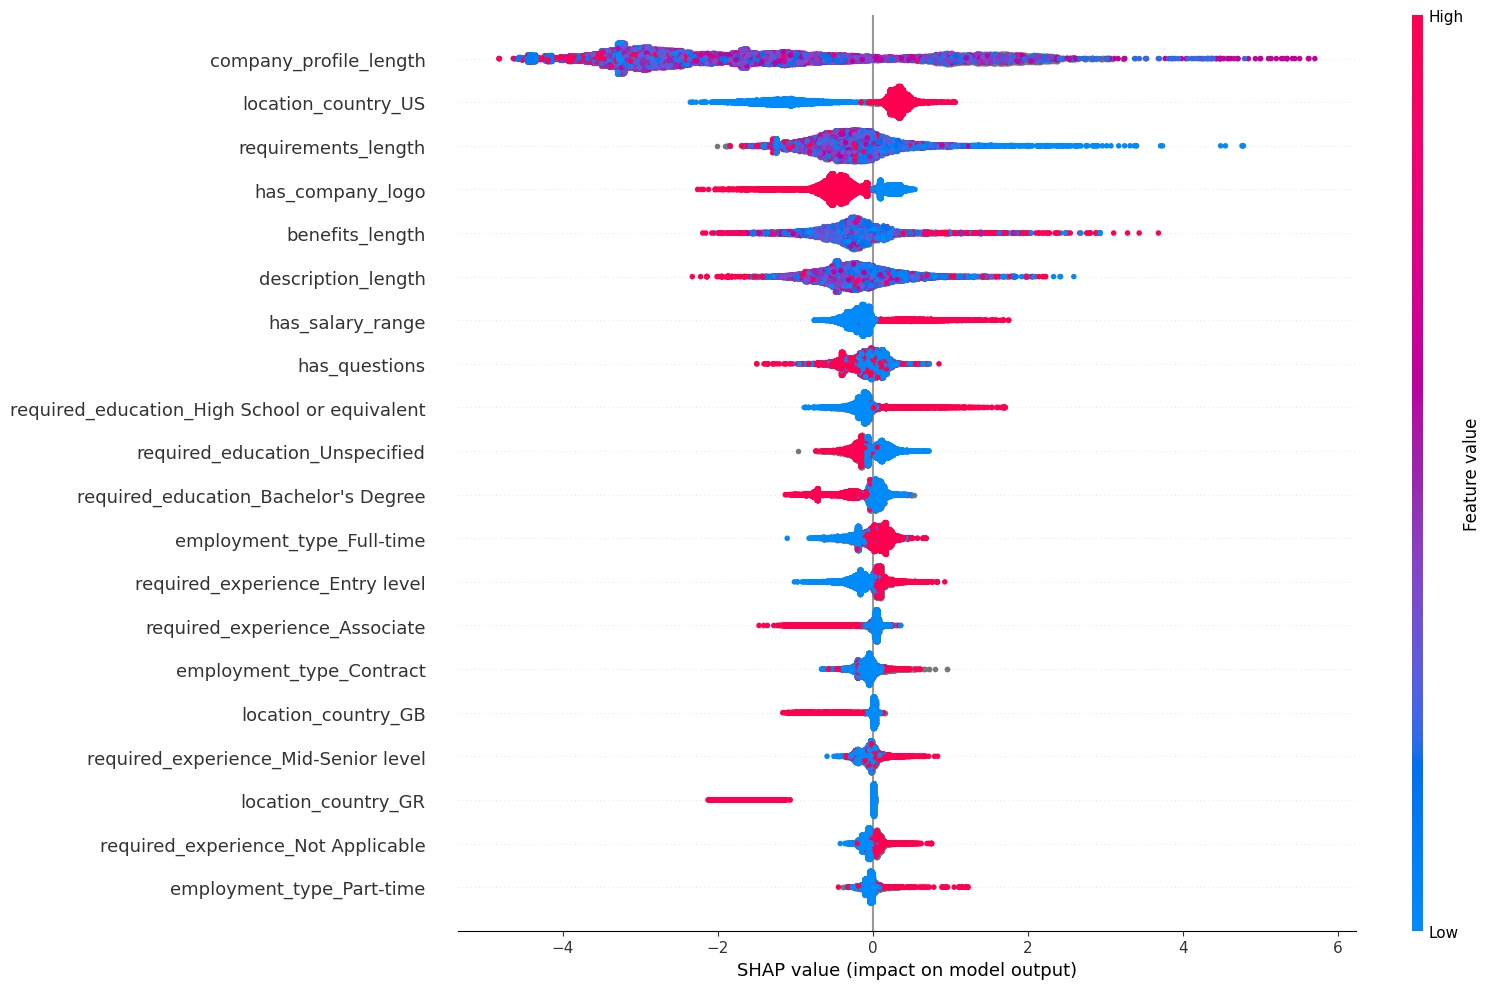

In [30]:
# Beeswarm plot
shap.summary_plot(shap_values, X, plot_size=(16,10))